In [1]:
import os
import numpy as np
import tensorflow as tf
import time

import matplotlib.pyplot as plt
%matplotlib inline

from conv_rmm_cell import ConvCell
from data import get_features
from utils import plot_confusion_matrix, cross_entropy, accuracy, get_spectogram

import librosa

tf.logging.set_verbosity(tf.logging.ERROR)

c:\soft\python36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def get_files(path):
    filenames = []
    for f in os.listdir(path):
        if os.path.isfile(os.path.join(path, f)) and f.endswith('.npz'):
            filenames.append(os.path.join(path, f))
    
    return filenames

# DATA_PATH = 'C:/Dataset/noisy_speech'
DATA_PATH = 'D:/musan/preprocessed/noisy_speech_v2'
FOLDERS = ['train', 'valid']

train_files = np.array([(filename, True) for filename in get_files(os.path.join(DATA_PATH, FOLDERS[0]))])
np.random.shuffle(train_files)

valid_files = np.array([(filename, False) for filename in get_files(os.path.join(DATA_PATH, FOLDERS[1]))])
np.random.shuffle(valid_files)

In [3]:
N_HARM = 14
N_CAND = 100
SEQ_LEN = 16
N_HIDDEM = 16
BATCH_SIZE = 128
# N_CLASS = 3

LR = 1e-4

In [4]:
# data = np.load('C:/Dataset/noisy_speech/train/speech-librivox-0002.wav.npz')
# data['labels'].shape, data['features'].shape

In [5]:
mean_std = np.load('mean-std.npz')

mean = mean_std['mean'][np.newaxis, np.newaxis, ...]
std = mean_std['std'][np.newaxis, np.newaxis, ...]

mean = tf.constant(mean, name='mean')
std = tf.constant(std, name='std')

seq_len_t = tf.constant(SEQ_LEN, dtype=tf.int32)

In [6]:
def load_file(path):
    path = path.decode()
    data = np.load(path)
    features = data['features']
    labels = data['labels'].astype(np.float32)
        
    if features.shape[0] < SEQ_LEN:
        return None

    return features, labels, features.shape[0]

def prepare_data(features, labels, length):
    n_batches = length // SEQ_LEN
    features = tf.reshape(features[:seq_len_t * n_batches], (n_batches, SEQ_LEN, N_CAND, N_HARM))
    targets = tf.reshape(labels[:seq_len_t * n_batches], (n_batches, SEQ_LEN, 1))
#     one_hot_labels = tf.one_hot(labels, N_CLASS)
#     one_hot_labels = tf.reshape(one_hot_labels[:seq_len_t * n_batches], (n_batches, SEQ_LEN, N_CLASS))[:, -1]
    
    return features, targets

In [7]:
with tf.name_scope('dataset'):
    filenames = tf.placeholder(dtype=train_files.dtype, name='filename')
#     is_speech_phr = tf.placeholder(dtype=tf.bool, name='is_speech')

    dataset = tf.data.Dataset().from_tensor_slices((filenames))
    dataset = dataset.map(lambda filename: tf.py_func(load_file, [filename], [tf.float32, tf.float32, tf.int32]), 4)
    dataset = dataset.apply(tf.contrib.data.ignore_errors())
    dataset = dataset.map(lambda features, labels, length: prepare_data(features, labels, length), 4)
    dataset = dataset.flat_map(lambda *samples: tf.data.Dataset().from_tensor_slices(samples))
    dataset = dataset.cache('C:/Dataset/cache/')
    dataset = dataset.repeat()
    dataset = dataset.shuffle(20000)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(buffer_size=1)
    
    train_iterator = dataset.make_initializable_iterator()
    valid_iterator = dataset.make_initializable_iterator()
    
    train_batch = train_iterator.get_next()
    valid_batch = valid_iterator.get_next()
    
    is_training = tf.placeholder_with_default(True, shape=None, name='is_training')

    batch_features, batch_targets = tf.cond(is_training, 
                                      true_fn=lambda: train_batch, 
                                      false_fn=lambda: valid_batch)   
#     batch_features = tf.reshape(batch_features, [-1, SEQ_LEN, N_CAND, N_HARM])

## Computation graph

In [8]:
with tf.name_scope('standardization'):
    nnet = batch_features - mean
    nnet /= std

with tf.variable_scope('CNN'):
    # regularizer = tf.contrib.layers.l1_regularizer(scale=0.0001)
    # nnet = tf.reshape(nnet, (-1, N_CAND, N_HARM, 1))
    nnet = tf.layers.conv2d(nnet, N_HIDDEM, kernel_size=[1, 1], activation=tf.nn.relu, name='Cond2D_1')
    conv_output = tf.layers.conv2d(nnet, 1, kernel_size=[1, 1], activation=tf.nn.sigmoid, name='Cond2D_2')
    # nnet = tf.reshape(nnet, (-1, SEQ_LEN, N_CAND))
    
with tf.name_scope('conv_output'):
    conv = tf.reshape(conv_output, [-1, N_CAND])
    conv_predictions = tf.reduce_max(conv, axis=1)
    
with tf.variable_scope('RNN'):
    cell = ConvCell((SEQ_LEN, N_CAND, 1), filters=1, kernel_size=32, padding='SAME', activation=tf.nn.sigmoid, name='recurent_cell')
    rnn_output, state = tf.nn.dynamic_rnn(cell, conv_output, sequence_length=[SEQ_LEN] * BATCH_SIZE, dtype=tf.float32)

with tf.name_scope('rnn_output_postprocessing'):
    nnet = tf.transpose(rnn_output, (1, 0, 2, 3))
    nnet = tf.gather(nnet, int(nnet.get_shape()[0]) - 1, name="last_rnn_output")
#     nnet = tf.reshape(rnn_output, [-1, N_CAND])

logits = tf.reduce_max(nnet, axis=(1, 2))
# predictions = tf.sigmoid(logits)
predictions = logits

with tf.name_scope('postprocessing'):
    classes = tf.cast(predictions > 0.5, tf.int32)
    cnn_classes = tf.cast(conv_predictions > 0.5, tf.int32)
    
    cnn_targets = tf.reshape(batch_targets, [-1, 1])
    cnn_targets = cnn_targets[:, 0]

    targets = tf.transpose(batch_targets, [1, 0, 2])
    targets = tf.gather(targets, int(targets.get_shape()[0]) - 1, name="last_batch_target")[:, 0]

## Losses

In [9]:
cnn_cost = cross_entropy(targets=cnn_targets, predictions=conv_predictions)
cnn_loss = tf.reduce_mean(cnn_cost)

output_cost = cross_entropy(targets=targets, predictions=predictions)
output_loss = tf.reduce_mean(output_cost)

loss = output_loss + cnn_loss

## Training operations

In [10]:
cnn_trainable_variables = tf.trainable_variables('CNN')
cnn_grads = tf.gradients(cnn_loss, cnn_trainable_variables, name='gradients_cnn')
cnn_optimizer = tf.train.MomentumOptimizer(LR, momentum=0.9)
cnn_train_op = cnn_optimizer.apply_gradients(zip(cnn_grads, cnn_trainable_variables))

rnn_trainable_variables = tf.trainable_variables('RNN')
rnn_grads = tf.gradients(output_loss, rnn_trainable_variables, name='gradients_rnn')
rnn_optimizer = tf.train.MomentumOptimizer(LR, momentum=0.9)
rnn_train_op = rnn_optimizer.apply_gradients(zip(rnn_grads, rnn_trainable_variables))

c:\soft\python36\lib\site-packages\tensorflow\python\ops\gradients_impl.py:98: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [11]:
cnn_accuracy = accuracy(cnn_classes, tf.cast(cnn_targets, tf.int32))
rnn_accuracy = accuracy(classes, tf.cast(targets, tf.int32))

In [12]:
rnn_cm = tf.confusion_matrix(labels=tf.cast(targets, tf.int32), predictions=classes, num_classes=2)
cnn_cm = tf.confusion_matrix(labels=tf.cast(cnn_targets, tf.int32), predictions=cnn_classes, num_classes=2)

def _plot_confusion_matrix_wrapper(confusion_matrix):
    return plot_confusion_matrix(confusion_matrix, {'Noise': 0, 'Voice': 1})

rnn_confusion_matrix_img = tf.py_func(_plot_confusion_matrix_wrapper, [rnn_cm], tf.uint8)
rnn_confusion_matrix_img = tf.expand_dims(rnn_confusion_matrix_img, axis=0)

cnn_confusion_matrix_img = tf.py_func(_plot_confusion_matrix_wrapper, [cnn_cm], tf.uint8)
cnn_confusion_matrix_img = tf.expand_dims(cnn_confusion_matrix_img, axis=0)

In [13]:
summaries = []

for grad in cnn_grads + rnn_grads:
    if not ('bias' in grad.name.lower()):
        tf.summary.scalar('gradients/'+grad.name, tf.reduce_mean(tf.abs(grad)))
        tf.summary.histogram('gradients/'+grad.name, grad)
        
for param in tf.trainable_variables():
    if not ('bias' in param.name.lower()):
        tf.summary.histogram('parameters/'+param.name, param)
        
summaries.append(tf.summary.scalar('losses/rnn_loss', output_loss))
# tf.summary.scalar('losses/l1_loss', l1_loss)
summaries.append(tf.summary.scalar('losses/total_loss', loss))
summaries.append(tf.summary.scalar('losses/cnn_loss', cnn_loss))
summaries.append(tf.summary.scalar('accuracy/rnn', rnn_accuracy))
summaries.append(tf.summary.scalar('accuracy/cnn', cnn_accuracy))

# tf.summary.audio()

summaries.append(tf.summary.image('confusion-matrix/rnn', rnn_confusion_matrix_img))
summaries.append(tf.summary.image('confusion-matrix/cnn', cnn_confusion_matrix_img))


train_summary_op = tf.summary.merge_all()
valid_summary_op = tf.summary.merge(summaries)

# spectr_summary_op = tf.summary.image('spectrogramm', img)

In [14]:
TRAINING_STEPS = 500000

In [15]:
saver = tf.train.Saver(tf.global_variables())
checkpoint_path = os.path.join('trained_model/new', 'model.ckpt')

In [16]:
sess = tf.Session()

options = tf.RunOptions(trace_level = tf.RunOptions.NO_TRACE)

train_writer = tf.summary.FileWriter('logdir/new/train', sess.graph)
valid_writer = tf.summary.FileWriter('logdir/new/valid')

sess.run(tf.global_variables_initializer(), options=options)

sess.run(train_iterator.initializer, 
         feed_dict={filenames: train_files[:, 0]}, options=options)

sess.run(valid_iterator.initializer, 
         feed_dict={filenames: valid_files[:, 0]}, options=options)
sess.graph.finalize()

started = False
for i in range(TRAINING_STEPS):
    if not started:
        start = time.time()
        started = True
        
    _ = sess.run(cnn_train_op, options=options)
    _ = sess.run(rnn_train_op, options=options)

    if i % 500 == 0:
        training_loss, summary  = sess.run([loss, train_summary_op], options=options)
        train_writer.add_summary(summary, i)

#         validation_loss = sess.run(loss, feed_dict={is_training: False}, options=options)

        validation_loss, summary = sess.run([loss, valid_summary_op], feed_dict={is_training: False}, options=options)
        valid_writer.add_summary(summary, i)

        saver.save(sess, checkpoint_path, i)
        
        finish = time.time()
        started = False
        print('\rStep %i. Training loss: %.5f. Validation loss: %.5f. Time: %s' % (i, training_loss, validation_loss, str(finish - start)), end='')
        
        

Step 499500. Training loss: 0.73123. Validation loss: 0.82458. Time: 76.77789282798767

In [19]:
for i in range(20):
#     plt.figure()
    plt.plot(wars[0, 0, :, i])

NameError: name 'wars' is not defined

In [20]:
wars.shape

(1024, 32, 100, 1)

In [27]:
wars.shape

(1024, 8, 100, 1)

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 1. 1. 1. 1. 1. 1. 1.]


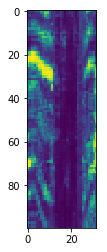

In [64]:
wars, tgs  = sess.run([conv_output, batch_targets])
print(tgs[16, :, 0])
plt.figure()
plt.imshow(wars[16, :, :, 0].T)

In [26]:
wars.shape

(1024, 32, 100, 1)

In [28]:
tgs.shape

(1024, 32, 1)